# Exploratory Data Analysis

Author: Alex Lim

This notebook dives into the dataset and outputs visualizations for more information about our data.

## Import Packages

In [7]:
from __future__ import (absolute_import, 
                        division, 
                        print_function, 
                        unicode_literals)

import os
import cv2
import glob
import time
import math
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import pylab
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import tensorflow as tf
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Set random seed for consistency
random.seed(100) 
np.random.seed(100)
tf.set_random_seed(100)

# Displays all outputs of a cell (not just last output)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 5]
print('TensorFlow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

TensorFlow version: 1.14.0
Keras version: 2.2.4-tf


## Define Directory Paths

In [2]:
work_dir = '.'
data_dir = os.path.join(work_dir, 'data')
data_arr_dir = os.path.join(work_dir, 'data_arr')
model_dir = os.path.join(work_dir, 'saved_models')

# Original data (before split)
black_measles_dir = os.path.join(data_dir, 'black_measles')
black_rot_dir = os.path.join(data_dir, 'black_rot')
leaf_blight_dir = os.path.join(data_dir, 'leaf_blight')
healthy_dir = os.path.join(data_dir, 'healthy')

# Train/Validation/Test
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

# Training data by class
train_black_measles_dir = os.path.join(train_dir, 'black_measles')
train_black_rot_dir = os.path.join(train_dir, 'black_rot')
train_leaf_blight_dir = os.path.join(train_dir, 'leaf_blight')
train_healthy_dir = os.path.join(train_dir, 'healthy')

# Validation data by class
validation_black_measles_dir = os.path.join(validation_dir, 'black_measles')
validation_black_rot_dir = os.path.join(validation_dir, 'black_rot')
validation_leaf_blight_dir = os.path.join(validation_dir, 'leaf_blight')
validation_healthy_dir = os.path.join(validation_dir, 'healthy')

# Test data by class
test_black_measles_dir = os.path.join(test_dir, 'black_measles')
test_black_rot_dir = os.path.join(test_dir, 'black_rot')
test_leaf_blight_dir = os.path.join(test_dir, 'leaf_blight')
test_healthy_dir = os.path.join(test_dir, 'healthy')

## Observe Data Distribution

In [3]:
num_black_measles = len(os.listdir(black_measles_dir))
num_black_rot = len(os.listdir(black_rot_dir))
num_leaf_blight = len(os.listdir(leaf_blight_dir))
num_healthy = len(os.listdir(healthy_dir))
total_images = num_black_measles + num_black_rot + num_leaf_blight + num_healthy
                                   
print('Total Images: {}'.format(total_images))
print('black_measles class has {} images'.format(num_black_measles))
print('black_rot class has {} images'.format(num_black_rot))
print('leaf_blight class has {} images'.format(num_leaf_blight))
print('healthy class has {} images'.format(num_healthy))

Total Images: 4062
black_measles class has 1383 images
black_rot class has 1180 images
leaf_blight class has 1076 images
healthy class has 423 images


In [4]:
pct_black_measles = (num_black_measles / total_images) * 100.0
pct_black_rot = (num_black_rot / total_images) * 100.0
pct_leaf_blight = (num_leaf_blight / total_images) * 100.0
pct_healthy = (num_healthy / total_images) * 100.0

print('Percentage of black_measles class: {:.2f}%'.format(pct_black_measles))
print('Percentage of black_rot class: {:.2f}%'.format(pct_black_rot))
print('Percentage of leaf_blight class: {:.2f}%'.format(pct_leaf_blight))
print('Percentage of healthy class: {:.2f}%'.format(pct_healthy))

Percentage of black_measles class: 34.05%
Percentage of black_rot class: 29.05%
Percentage of leaf_blight class: 26.49%
Percentage of healthy class: 10.41%


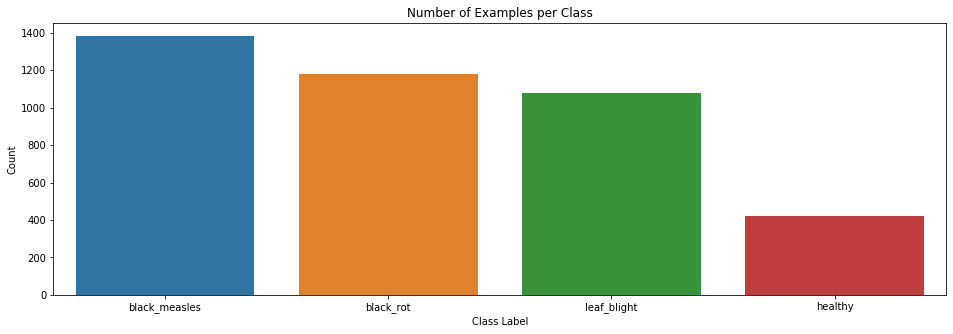

In [8]:
data_dist = pd.DataFrame.from_dict(data={ 'black_measles': [num_black_measles],
                                          'black_rot': [num_black_rot],
                                          'leaf_blight': [num_leaf_blight],
                                          'healthy': [num_healthy] } )
sns.barplot(data=data_dist);
plt.xlabel('Class Label');
plt.ylabel('Count');
plt.title('Number of Examples per Class');

## Observe Data Sample

In this section, we want to take a look at our image data and get an idea about what we are dealing with.

In [9]:
def read_img(filepath, size):
  """
  Helper function to convert an image into a Numpy array.
  @param filepath - path to the image
  @param size - size to resize the image to
  """
  img = image.load_img(filepath, target_size=size)
  img = image.img_to_array(img)
  return img

/home/alex/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


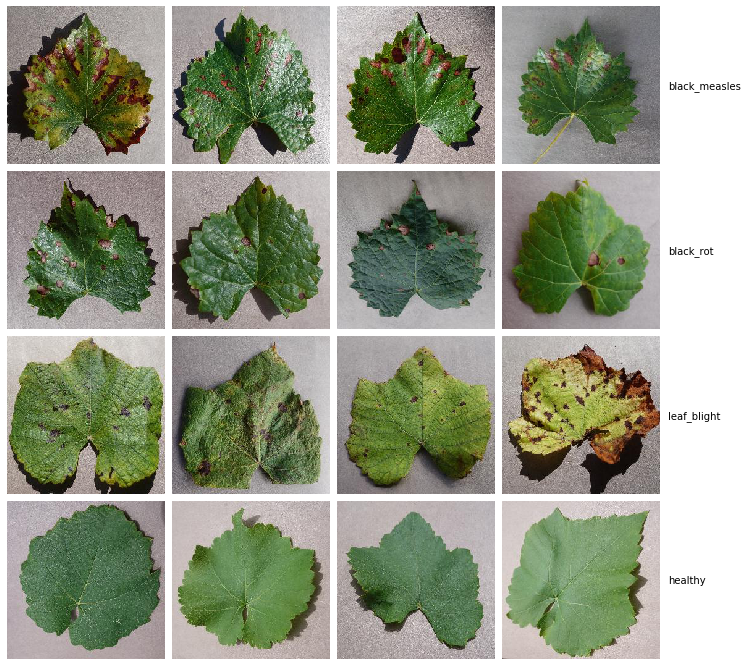

In [11]:
CATEGORIES = ['black_measles', 'black_rot', 'leaf_blight', 'healthy']
NUM_CATEGORIES = len(CATEGORIES)
height, width = 256, 256

# Create image grid
fig = plt.figure(num=1, figsize=(12,12))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES,NUM_CATEGORIES),
                 axes_pad=0.1) # pad between axes in inch.

# Plot each example image per grid square
i = 0
for category in CATEGORIES:
  for j in range(4):
    ax = grid[i]
    path = os.path.join(data_dir, category)
    file = category + str(j) + '.jpg'
    img = read_img(os.path.join(path, file), size=(height, width))
    ax.imshow(img/255., interpolation='nearest', aspect='auto')
    ax.axis('off')
    if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
      ax.text(x=height*1.05, y=height//2, s=category, verticalalignment='center')
    i += 1

fig.show();

We can see some distinctions between the classes (circular black dots for black rot, non-globular brown spots for black measles, etc.). However, most of the images may seem very similar and it is important to observe whether there is a clear distinction between classes. 

In [15]:
# Black measles Numpy array
os.makedirs(os.path.join(data_arr_dir), exist_ok=True)

black_measles_arr = [read_img(os.path.join(train_black_measles_dir, img), \
                    (256, 256)) for img in os.listdir(train_black_measles_dir)]

# Black rot Numpy array
black_rot_arr = [read_img(os.path.join(train_black_rot_dir, img), \
                 (256, 256)) for img in os.listdir(train_black_rot_dir)]

# Leaf blight Numpy array
leaf_blight_arr = [read_img(os.path.join(train_leaf_blight_dir, img), \
                   (256, 256)) for img in os.listdir(train_leaf_blight_dir)]

# Healthy Numpy array
healthy_arr = [read_img(os.path.join(train_healthy_dir, img),\
               (256, 256)) for img in os.listdir(train_healthy_dir)]

# Save Numpy arrays of images
np.save(os.path.join(data_arr_dir, 'black_measles.npy'), arr=black_measles_arr)
np.save(os.path.join(data_arr_dir, 'black_rot.npy'), arr=black_rot_arr)
np.save(os.path.join(data_arr_dir, 'leaf_blight.npy'), arr=leaf_blight_arr)
np.save(os.path.join(data_arr_dir, 'healthy.npy'), arr=healthy_arr)

In [16]:
# Load Numpy arrays of images
black_measles_arr = np.load(os.path.join(data_arr_dir, 'black_measles.npy'))
black_rot_arr = np.load(os.path.join(data_arr_dir, 'black_rot.npy'))
leaf_blight_arr = np.load(os.path.join(data_arr_dir, 'leaf_blight.npy'))
healthy_arr = np.load(os.path.join(data_arr_dir, 'healthy.npy'))

In [23]:
# Reshape arrays
black_measles_arr = black_measles_arr.reshape(886, 256*256*3)
black_rot_arr = black_rot_arr.reshape(756, 256*256*3)
leaf_blight_arr = leaf_blight_arr.reshape(689, 256*256*3)
healthy_arr = healthy_arr.reshape(272, 256*256*3)

### t-Distributed Stochatic Neighbor Embedding (t-SNE)

t-SNE is a dimensionality reduction technique that is particularly well suited for the visualization of high-dimensional datasets. Because our input image dimensionality is (256, 256, 3) = 256\*256\*3 = 196,608 dimensions, t-SNE is a good choice to attempt to visualize whether there is a clear distinction between classes. It is recommended to first run a different dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g., 50) if the number of features is very high. The purpose of this is to suppress some noise and speed up the computation of pairwise distances between samples. 

In [25]:
def pca(X=np.array([]), no_dims=50):
  """
  Runs PCA on an array X to reduce its dimensoinality to 
  no_dims dimensions.
  @param X - the data matrix to reduce dimensionality
  @param no_dims - the number of dimensions to reduce dimensionality to
  """
  print('Running PCA on the data...')
  mean_vec = np.mean(a=X, axis=0)
  X_cov = (X-mean_vec).T.dot(X-mean_vec) / (X.shape[0]-1)
  eig_vals, eig_vecs = np.linalg.eig(X_cov.T)
  idx = np.argsort(np.abs(eig_vals))[::-1]
  eig_vecs = eig_vecs[:, idx]
  Y = np.dot(X, eig_vecs[:, 0:no_dims])
  return Y

def plot_scatter(x, labels):
  """
  Function to create a scatter plot for visualization of data
  along with respective colors/labels.
  @param X - 2D Numpy array of data reduced to 2-dimensions using t-SNE or PCA
  @param labels - 1D Numpy array of class label strings
  """
  num_classes = len(np.unique(labels))
  color_palette = np.array(sns.color_palette('hls', num_classes))
  f = plt.figure(figsize=(10,10))
  ax = plt.subplot(aspect='equal')
  for i, label in enumerate(np.unique(labels)):
    idx = np.where(labels == label)
    ax.scatter(x[idx,0], x[idx,1], s=30, alpha=0.6, 
                    c=[color_palette[i]], label=label)
  ax.legend(loc='best', fontsize='medium')
  ax.axis('off')
  ax.axis('tight')
  plt.title('Visualization of Classes in 2D')

In [26]:
# Create the 1D array of class labels
black_measles_lab = np.full(black_measles_arr.shape[0], 'black_measles')
black_rot_lab = np.full(black_rot_arr.shape[0], 'black_rot')
leaf_blight_lab = np.full(leaf_blight_arr.shape[0], 'leaf_blight')
healthy_lab = np.full(healthy_arr.shape[0], 'healthy')

labels = (black_measles_lab, black_rot_lab, leaf_blight_lab, healthy_lab)
labels = np.hstack(labels) 

In [27]:
labels.shape

(2603,)

In [28]:
# Create a stacked array of the training instances 
data_tuple = (black_measles_arr, black_rot_arr, leaf_blight_arr, healthy_arr)
data = np.vstack(tup=data_tuple)/255. # normalize 

In [29]:
data.shape

(2603, 196608)

In [30]:
# Run PCA on data
start = time.time()
pca = PCA(n_components=50)
data_pca = pca.fit_transform(data)
end = time.time()

print('Took {:.2f} seconds.'.format(end-start))

Took 7.41 seconds.


In [31]:
data_pca.shape

(2603, 50)

In [32]:
# Run t-SNE on data
start = time.time()
tsne = TSNE(n_components=2)
data_tsne = tsne.fit_transform(data_pca)
end = time.time()

print('Took {:.2f} seconds'.format(end-start))

Took 20.39 seconds


In [33]:
data_tsne.shape

(2603, 2)

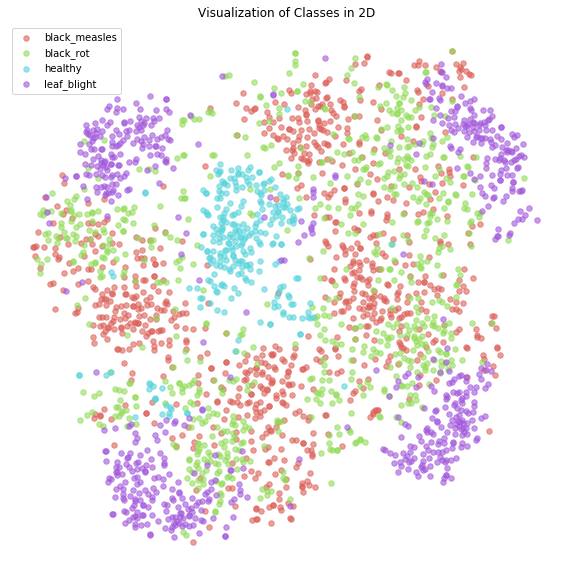

In [34]:
# Visualize the 2D class scatter plot
plot_scatter(data_tsne, labels);